In [1]:
import numpy as np
import pandas as pd
import pickle
import glob
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.exceptions import NotFittedError
from sklearn.metrics import accuracy_score, f1_score

Build vocabulary.

In [2]:
neg_files = glob.glob("txt_sentoken/neg/*.txt")
pos_files = glob.glob("txt_sentoken/pos/*.txt")
files = neg_files + pos_files
vocab = {}
index = 0
for file in files:
    with open(file) as f:
        raw_txt = f.read()
    txt_arr = raw_txt.split()
    for token in txt_arr:
        if token not in vocab:
            vocab[token] = index
            index += 1
            
pickle.dump(vocab, open("vocab.pkl", "wb"))

Generate word count feature vectors for each document.

In [3]:
vocab_size = len(vocab)
n = len(files)
n_neg = len(neg_files)
n_pos = len(pos_files)

X = np.zeros((n, vocab_size), dtype=np.int8)
y = np.concatenate((np.repeat(0, n_neg), np.repeat(1, n_pos))).astype(np.int8)

for i, file in enumerate(files):
    with open(file) as f:
        raw_txt = f.read()
    txt_arr = raw_txt.split()
    for token in txt_arr:
        X[i, vocab[token]] = 1

In [4]:
feature_means = np.mean(X, axis = 0)
vocab_size = len(feature_means)

threshold = 0.0
above_idx = feature_means > threshold
num_above = np.sum(above_idx)
frac_above = num_above / vocab_size

print("%d words out of %d words have above %f instances in each document on average (%0.3f)." % (num_above, vocab_size, threshold, frac_above))

50920 words out of 50920 words have above 0.000000 instances in each document on average (1.000).


In [5]:
X = X[:, above_idx]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400)

pickle.dump(X_train, open("X_train.pkl", "wb"))
pickle.dump(X_test, open("X_test.pkl", "wb"))
pickle.dump(y_train, open("y_train.pkl", "wb"))
pickle.dump(y_test, open("y_test.pkl", "wb"))

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=400)

pickle.dump(X_train, open("X_train.pkl", "wb"))
pickle.dump(X_test, open("X_test.pkl", "wb"))
pickle.dump(y_train, open("y_train.pkl", "wb"))
pickle.dump(y_test, open("y_test.pkl", "wb"))

Load train and test data.

In [23]:
X_train = pickle.load(open("X_train.pkl", "rb"))
X_test = pickle.load(open("X_test.pkl", "rb"))
y_train = pickle.load(open("y_train.pkl", "rb"))
y_test = pickle.load(open("y_test.pkl", "rb"))

vocab = pickle.load(open("vocab.pkl", "rb"))

print("Train size:", len(X_train))
print("Test size:", len(X_test))
print("Vocabulary size:", len(vocab))
print()
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

Train size: 1600
Test size: 400
Vocabulary size: 50920

X_train shape: (1600, 50920)
X_test shape: (400, 50920)
y_train shape: (1600,)
y_test shape: (400,)


Run Multinomial Logistic Regression algorithm.

In [19]:
class MultinomialLogisticRegressor():
    
    def __init__(self, lambda_, batch_size, epochs, lr, verbose):
        self.lambda_ = lambda_
        self.batch_size = batch_size
        self.epochs = epochs
        self.lr = lr
        self.verbose = verbose
    
    def fit(self, X, y):
        
        n, d = X.shape
        X_appended = np.concatenate((np.ones((n, 1)), X), axis=1)
        if not hasattr(self, 'weights'):
            self.weights = np.random.normal(size=d+1)
        checkpoint = self.epochs // 10
        
        losses = []
        for epoch in range(self.epochs):
            
            order = np.random.permutation(n)
            num_batch = n // self.batch_size
            
            for i in range(num_batch):
                indices = order[i:min(i + batch_size, n)]
                X_batch = X_appended[indices]
                y_batch = y[indices]
                
                self.gradient_step(X_batch, y_batch)
                
            # Compute training loss.
            if verbose and (epoch % checkpoint == 0):
                logits = np.dot(X_appended, self.weights)
                probs = self.sigmoid(logits)
                loss = (-(y * np.log(probs) + (1 - y) * np.log(1 - probs)).sum() + self.lambda_ * np.sum(np.abs(self.weights))) / n
                
                y_pred = (1 + np.sign(logits)) / 2
                train_error = np.mean(np.abs(y - y_pred))
                print("Epoch %d \t cross entropy loss: %0.4f train error %0.3f" % (epoch, loss, train_error))
                
                losses.append(loss)
            
                
        self.fitted = True
        return losses
    
    def predict(self, X):
        
        if not hasattr(self, 'fitted'):
            raise NotFittedError("This MultinomialLogisticRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.")
            
        n = len(X)
        X_appended = np.concatenate((np.ones((n, 1)), X), axis=1)
        
        return (1 + np.sign(np.dot(X_appended, self.weights))) / 2
    
    def gradient_step(self, X, y):
        
        # Use l1 regularization.
        
        n = len(X)
        probs = self.sigmoid(np.dot(X, self.weights))
        grad = (np.dot(X.T, (probs - y)) + self.lambda_ * self.weights) / n
        self.weights = self.weights - self.lr * grad
        
    def sigmoid(self, Z):
        Z_clipped = np.clip(Z, -10, 10)
        return 1 / (1 + np.exp(-Z_clipped))

See if the code works on a toy example.

In [33]:
n = 1000
d = 10

mu = 3 * np.ones(d)
cov = np.eye(d)

X_neg = np.random.multivariate_normal(-mu, cov, size = n // 2)
y_neg = np.repeat(0, n // 2)
X_pos = np.random.multivariate_normal(mu, cov, size = n // 2)
y_pos = np.repeat(1, n // 2)

X = np.concatenate((X_neg, X_pos))
y = np.concatenate((y_neg, y_pos))

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33)

batch_size = 32
epochs = 100
verbose = True
lr = 0.03
lambda_ = 0.001

mlr = MultinomialLogisticRegressor(lambda_=lambda_, batch_size=batch_size, epochs=epochs, lr=lr, verbose=verbose)
mlr.fit(X_tr, y_tr)
y_pred = mlr.predict(X_te)

test_acc = accuracy_score(y_te, y_pred)
print(test_acc)

Epoch 0 	 cross entropy loss: 0.0197 train error 0.001
Epoch 10 	 cross entropy loss: 0.0020 train error 0.000
Epoch 20 	 cross entropy loss: 0.0010 train error 0.000
Epoch 30 	 cross entropy loss: 0.0006 train error 0.000
Epoch 40 	 cross entropy loss: 0.0006 train error 0.000
Epoch 50 	 cross entropy loss: 0.0005 train error 0.000
Epoch 60 	 cross entropy loss: 0.0004 train error 0.000
Epoch 70 	 cross entropy loss: 0.0003 train error 0.000
Epoch 80 	 cross entropy loss: 0.0003 train error 0.000
Epoch 90 	 cross entropy loss: 0.0003 train error 0.000
1.0


Run with better hyperparameters.

In [29]:
batch_size = 64
epochs = 300
verbose = True
lr = 0.03
lambda_ = 0

mlr = MultinomialLogisticRegressor(lambda_=lambda_, batch_size=batch_size, epochs=epochs, lr=lr, verbose=verbose)

# 1. Does the loss monotonically decrease? -> 
# - yes: increase learning rate until no. Move to 2.
# - no: decrease learning rate.
# 2. Does the model optimize?
# - yes: Move to 3.
# - no: Increase epochs.
# 3. Is there a lare gap between train acc and val acc?
# - yes: increase lambda. Move to 1.
# - no: Move to 4.
# Is the performance reasonable?
# - yes: You're done!
# - no: decrease lambda. Move to 1.

Epoch 0 	 cross entropy loss: 3.5150 train error 0.464
Epoch 30 	 cross entropy loss: 2.4097 train error 0.349
Epoch 60 	 cross entropy loss: 1.6803 train error 0.274
Epoch 90 	 cross entropy loss: 1.1966 train error 0.191
Epoch 120 	 cross entropy loss: 0.9178 train error 0.167
Epoch 150 	 cross entropy loss: 0.6522 train error 0.117
Epoch 180 	 cross entropy loss: 0.4932 train error 0.097
Epoch 210 	 cross entropy loss: 0.3963 train error 0.076
Epoch 240 	 cross entropy loss: 0.2947 train error 0.054
Epoch 270 	 cross entropy loss: 0.2195 train error 0.041


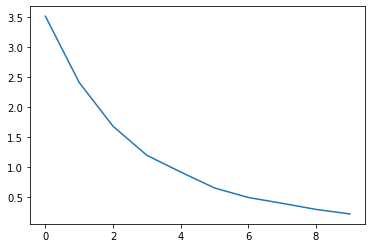

In [30]:
try:
    losses = mlr.fit(X_train, y_train)
    plt.plot(np.arange(len(losses)), losses)
except KeyboardInterrupt:
    print('Graceful Exit')

In [31]:
y_pred = mlr.predict(X_test)

test_error = np.mean(np.abs(y_test - y_pred))

print("Test error: ", test_error)

Test error:  0.315


In [32]:
pickle.dump(mlr, open("model.pkl", "wb"))